# Imports

In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import print_function
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import os
import sys
import json
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM,Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,UpSampling1D, Conv1DTranspose,GaussianNoise 
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback
from keras.regularizers import l2 , l1, l1_l2
import tensorflow.keras.backend as kb
print('keras version ', keras.__version__)
from IPython.display import clear_output
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical

keras version  2.9.0


# Config

In [2]:
window_size = 100
tp = 2
sp = 2
max_range_allowed = 30
validation_size = 0.2
test_size = 0.2

# Load CSV

In [3]:
data1 = pd.read_csv("./Data/01/XAUUSD1.csv", sep="\t", header=None)
data1.columns = ["Time", "Open", "High", "Low", "Close", "Volume"]
data1.head(2)

,Time,Open,High,Low,Close,Volume
0,2022-08-02 22:02,1761.724,1761.784,1761.208,1761.264,1
1,2022-08-02 22:03,1761.244,1761.754,1761.148,1761.438,1


In [4]:
data2 = pd.read_csv("./Data/02/XAUUSD_M1.csv", sep="\t")
data2['Time'] = data2['Time'].apply(lambda x: x[:-3])
data2.head(2)

,Time,Open,High,Low,Close,Volume
0,2022-12-09 01:06,1791.348,1791.538,1791.248,1791.258,1
1,2022-12-09 01:07,1791.178,1791.577,1791.168,1791.538,1


In [5]:
s1 = set(data1["Time"])
s2 = set(data2["Time"])
data1 = data1[data1["Time"].isin(s1 - s2)]

In [6]:
data = pd.concat([data1, data2])
print(data.shape)
data.head(2)

(331486, 6)


,Time,Open,High,Low,Close,Volume
0,2022-08-02 22:02,1761.724,1761.784,1761.208,1761.264,1
1,2022-08-02 22:03,1761.244,1761.754,1761.148,1761.438,1


In [7]:
data = data.sort_values(by='Time')
data.head(2)

,Time,Open,High,Low,Close,Volume
0,2022-08-02 22:02,1761.724,1761.784,1761.208,1761.264,1
1,2022-08-02 22:03,1761.244,1761.754,1761.148,1761.438,1


# Create dataset

In [8]:
def normalize_zero_base(array):
    min_val = array.min(axis=0)
    max_val = array.max(axis=0)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array


def standardization(array):
    mean = array.mean(axis=0)    
    std = np.array([x[:,i].std() for i in range(x.shape[1])])            
    return (array - mean) / std

def standardization(array):
    mean = x.mean()
    std = x.std()   
    return (array - mean) / std

In [9]:
features = []
targets = []
values = data.values
for i in tqdm(range(window_size, data.shape[0])):    
    x = values[i-window_size:i, 1:-1]    
    x = standardization(x)
    features.append(x)
    price = values[i-1, 4]        
    decistion = False
    counter = 0
    for j in range(i, data.shape[0]):
        counter += 1 
        low = values[j, 3]
        high = values[j, 2]         
        if((price - sp) >= low):
            targets.append(-1)
            decistion = True             
            break
        
        if((price + tp) <= high):
            targets.append(1)
            decistion = True            
            break
            
        if(counter >= max_range_allowed):
            break
    if(not decistion):
        targets.append(0)        

100%|██████████| 331386/331386 [02:30<00:00, 2208.44it/s]


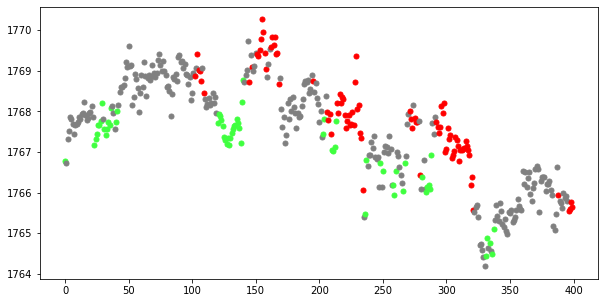

In [10]:
plt.figure(figsize=(10,5))
for i in range(window_size, 500):
    if(targets[i-window_size] == 1):
        color = [0.25, 1., 0.25, 1. ]
    if(targets[i-window_size] == -1):
        color = [1., 0, 0, 1. ]
    if(targets[i-window_size] == 0):
        color = [0.5, 0.5, 0.5 ]        
    plt.plot(i-window_size, values[i,4] , marker='o', markersize=5, color=color)
plt.show()

# Train and test split

In [11]:
def train_test_split(features, targets, test_size):    
    split = len(features) - int(test_size * len(features))
    x_train = features[:split]
    y_train = targets[:split]
    x_test = features[split:]
    y_test = targets[split:]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = train_test_split(features, targets, test_size)
x_train, y_train, x_val, y_val = train_test_split(x_train, y_train, validation_size)

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
print(len(x_val), len(y_val))

212088 212088
66277 66277
53021 53021


# Change dataset types

In [12]:
x_train = np.array(x_train).astype("float32")
y_train = np.array(y_train).astype("float32")
x_val = np.array(x_val).astype("float32")
y_val = np.array(y_val).astype("float32")
x_test = np.array(x_test).astype("float32")
y_test = np.array(y_test).astype("float32")

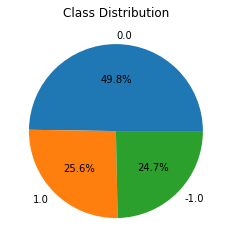

In [13]:
freq = pd.Series(y_train).value_counts()
plt.pie(freq.values, labels=freq.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

In [14]:
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Class weight

In [15]:
freq = y_train.sum(axis=0)
class_weight = {
    0: freq[0]/ freq[0],
    1: freq[0]/ freq[1],
    2: freq[0]/ freq[2]
}
class_weight

{0: 1.0, 1: 1.9469422, 2: 2.0159698}

# Deep learning model

In [16]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LSTM(32))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100, 64)           320       
                                                                 
 lstm (LSTM)                 (None, 100, 64)           33024     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 batch_normalization (BatchN  (None, 100, 64)          256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [17]:
model = Sequential()
model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               51328     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                      

# Train the model

In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['acc']
)

epochs = 100
batch_size = 32

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

history = model.fit(x_train, 
                    y_train,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[es],
                    class_weight=class_weight
                   )

Epoch 1/100
6628/6628 [==============================] - 37s 5ms/step - loss: 1.6513 - acc: 0.3551 - val_loss: 1.0919 - val_acc: 0.3833
Epoch 2/100
6628/6628 [==============================] - 34s 5ms/step - loss: 1.6254 - acc: 0.4283 - val_loss: 1.0856 - val_acc: 0.4159
Epoch 4/100
6628/6628 [==============================] - 34s 5ms/step - loss: 1.6214 - acc: 0.4368 - val_loss: 1.0825 - val_acc: 0.4105
Epoch 5/100
6628/6628 [==============================] - 34s 5ms/step - loss: 1.6188 - acc: 0.4414 - val_loss: 1.0778 - val_acc: 0.4260
Epoch 6/100
6628/6628 [==============================] - 34s 5ms/step - loss: 1.6178 - acc: 0.4414 - val_loss: 1.0740 - val_acc: 0.4283
Epoch 7/100
6628/6628 [==============================] - 34s 5ms/step - loss: 1.6161 - acc: 0.4406 - val_loss: 1.0760 - val_acc: 0.4220
Epoch 8/100
6628/6628 [==============================] - 35s 5ms/step - loss: 1.6153 - acc: 0.4424 - val_loss: 1.0747 - val_acc: 0.4331
Epoch 9/100
6628/6628 [=========================

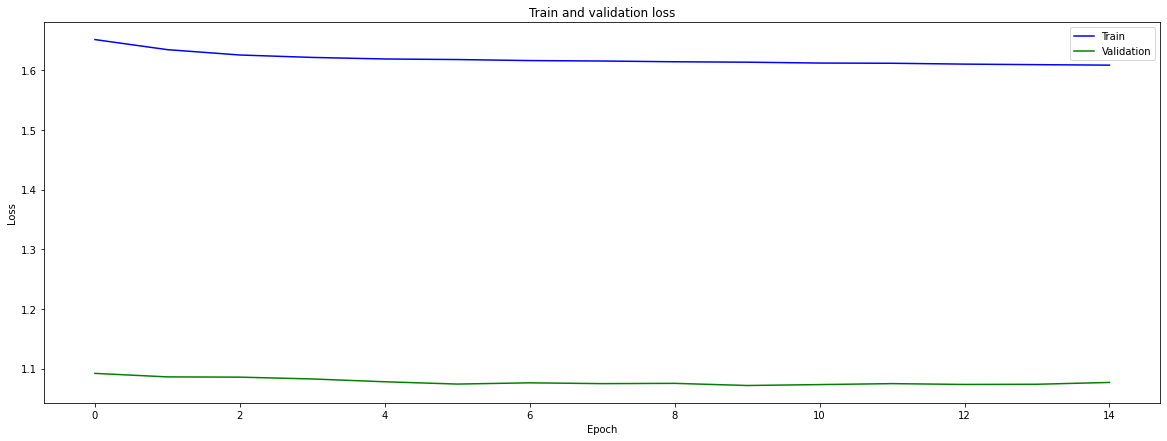

In [19]:
linewidth = 1.5
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'],'b',linewidth=linewidth)
plt.plot(history.history['val_loss'],'g',linewidth=linewidth)
plt.title(f'Train and validation loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [20]:
def show_confusion_matrix(validations, predictions, LABELS=['Down', 'UP']):            
    freq = metrics.confusion_matrix(validations, predictions)        
    sensitivity =  (np.divide(freq.transpose(),
                             np.sum(freq, axis=1)).transpose() * 100).round(2)    
    annotation = []
    for i in range(freq.shape[0]):
        row = []
        for j in range(freq.shape[1]):
            row.append(f'{freq[i][j]}\n {sensitivity[i][j]}%')            
        annotation.append(row)
    annotation = np.array(annotation)
    sns.heatmap(sensitivity, cmap="YlOrBr",
                vmin=0, vmax=100,
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=annotation,
               fmt=':<')    
    plt.title("Confusion Matrix")
    plt.ylabel("Actually Label")
    plt.xlabel("Predicted Label")
    plt.show()            

6628/6628 [==============================] - 13s 2ms/step


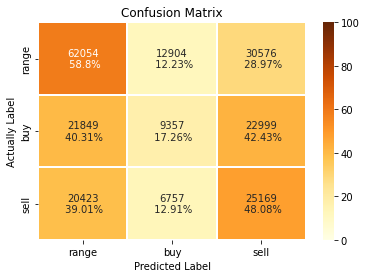

In [21]:
y_pred = model.predict(x_train).squeeze().argmax(axis=1)
show_confusion_matrix(y_train.argmax(axis=1), y_pred, LABELS=["range", "buy", "sell"])

1657/1657 [==============================] - 3s 2ms/step


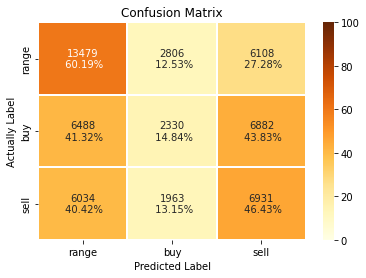

In [22]:
y_pred = model.predict(x_val).squeeze().argmax(axis=1)
show_confusion_matrix(y_val.argmax(axis=1), y_pred, LABELS=["range", "buy", "sell"])